# 04.4 American Options (Optimal Stopping, Snell Envelope & Pricing in Black–Scholes)

<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**
- Revisit optimal stopping and the Snell envelope inside the Black–Scholes model.
- Connect early exercise decisions to risk‐neutral valuation and dynamic hedging.
- Show why an American call without dividends should never be exercised early.
- Implement a full numerical pricing algorithm (binomial backward induction).
- Extract and visualise the early-exercise boundary of an American put.
- Compare American vs European prices and quantify the early‐exercise premium.

**This notebook**

Builds on the theoretical foundations already developed in Section 02 (02-Optimal_Stopping-American_Options/), where stopping times, Snell envelopes, and dynamic programming were introduced in a general probabilistic framework. Here, we move from abstract theory to full practical implementation within the Black–Scholes model: we express the American pricing problem as an optimal stopping problem under the risk-neutral measure, we compute the Snell envelope numerically on a discrete time grid, we identify stopping vs continuation regions, and we analyse the early-exercise logic from a financial perspective.

The core idea is to combine theory, simulation, and interpretation in a single unified example: pricing an American put and understanding exactly when and why early exercise occurs.

# 1. American options as an optimal stopping problem

A discounted payoff process:

$$Y_t = e^{-rt} \psi(S_t), \quad \psi(S) = (K-S)^+ \text{ (put)}, \quad (S-K)^+ \text{ (call)}.$$

The price of the American option at time $t$ is

$$u(t, S_t) = \sup_{\tau \in \mathcal{T}_{t,T}} E^*\!\left[\, e^{-r(\tau-t)} \psi(S_\tau) \,|\, \mathcal{F}_t \,\right].$$

This is a continuous-time optimal stopping problem.

The value process

$$Z_t = e^{-rt} u(t, S_t)$$

is the Snell envelope of $(Y_t)$.

**Properties:**

- $Z_t \geq Y_t$
- $Z$ is the smallest supermartingale dominating $Y$.
- Exercise occurs when $Y_t = Z_t$.

**In the Black–Scholes model:**

- **Continuation region:** $u(t,S) > \psi(S)$
- **Stopping region:** $u(t,S) = \psi(S)$


# 2. Why an American call without dividends should never be exercised early ?

We often hear that an American call on a stock without dividends should never be exercised early. But why is that always true? Let’s break it down clearly.

For a call $\psi(S) = (S - K)^+$:

- Selling the option yields $C(t, S)$.
- Exercising yields $S - K$ and loses the time value.
- Keeping the option preserves convexity and the upside from future volatility.

**Key fact:**
Under no dividends, the discounted price process $e^{-rt} C(t, S_t)$ is a martingale under $P^*$.

Since exercising gives a submartingale payoff:

$$e^{-rt} (S_t - K)^+ \leq e^{-rt} C(t, S_t),$$

exercising early is never optimal.

**Thus:**

$$\text{American Call (no dividends)} = \text{European Call}$$


# 3. Backward induction (numerical scheme)

In this section, we compute the American option price using a discrete-time dynamic programming scheme.

We discretise the interval

$$0 = t_0 < t_1 < \cdots < t_N = T,$$

and construct a stock price tree (binomial-style).

At each node $(i,k)$, we define:

**Intrinsic value**

$$\psi(S_{i,k})$$

**Continuation value** (discounted expected value of next step)

$$C_{i,k} = e^{-r\Delta t} \left( p \, V_{i+1,k+1} + (1-p) \, V_{i+1,k} \right)$$

**American value**

$$V_{i,k} = \max\{\psi(S_{i,k}), \, C_{i,k}\}.$$

By going backward from maturity to time 0, we obtain both the American option price and the optimal exercise boundary.


# 4. Python implementation: Pricing an American put (binomial method)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

rng = np.random.default_rng(123)

plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams["axes.grid"] = True

In [2]:
def american_put_binomial(S0, K, r, sigma, T, N):
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt) - d)/(u-d)

    # Stock tree
    S = np.zeros((N+1, N+1))
    S[0,0] = S0
    for i in range(1, N+1):
        S[i,0] = S[i-1,0]*u
        for j in range(1, i+1):
            S[i,j] = S[i-1,j-1]*d

    # Option values
    V = np.zeros_like(S)
    V[N,:] = np.maximum(K - S[N,:], 0.0)

    # Backward induction
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            continuation = np.exp(-r*dt)*(p*V[i+1,j] + (1-p)*V[i+1,j+1])
            exercise = K - S[i,j]
            V[i,j] = max(exercise, continuation)

    return V[0,0]

# 5. Numerical experiment

We now study the numerical convergence of the binomial price as we refine the time grid. We fix $S_0=100$, $K=100$, $r=5\%$, $\sigma=20\%$ and $T=1$.


In [3]:
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1.0

for N in [50, 100, 200, 500, 1000]:
    price = american_put_binomial(S0,K,r,sigma,T,N)
    print(f"N={N:4d}  American Put Price ≈ {price:.4f}")

N=  50  American Put Price ≈ 6.0737
N= 100  American Put Price ≈ 6.0824
N= 200  American Put Price ≈ 6.0864
N= 500  American Put Price ≈ 6.0888
N=1000  American Put Price ≈ 6.0896


As 𝑁 increases, the American put price stabilises around 6.09, illustrating the convergence of the binomial scheme as the time step becomes smaller.

# 6. Early-exercise boundary (estimated)

We extract the stopping boundary:

In [ ]:
def american_put_boundary(S0, K, r, sigma, T, N):
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt) - d)/(u-d)

    S = np.zeros((N+1, N+1))
    V = np.zeros_like(S)

    S[0,0] = S0
    for i in range(1, N+1):
        S[i,0] = S[i-1,0]*u
        for j in range(1, i+1):
            S[i,j] = S[i-1,j-1]*d

    V[N,:] = np.maximum(K - S[N,:], 0.0)
    boundary = []

    for i in range(N-1, -1, -1):
        boundary_S = None
        for j in range(i+1):
            continuation = np.exp(-r*dt)*(p*V[i+1,j] + (1-p)*V[i+1,j+1])
            exercise = K - S[i,j]
            V[i,j] = max(exercise, continuation)
            if exercise >= continuation and boundary_S is None:
                boundary_S = S[i,j]
        boundary.append((i, boundary_S))

    return np.array(boundary[::-1])

We plot :

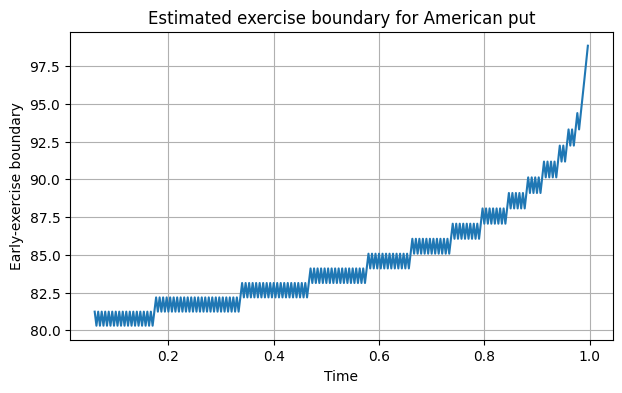

In [5]:
boundary = american_put_boundary(S0,K,r,sigma,T,300)

times = boundary[:,0]* (T/300)
levels = boundary[:,1]

plt.plot(times, levels)
plt.xlabel("Time")
plt.ylabel("Early-exercise boundary")
plt.title("Estimated exercise boundary for American put")
plt.show()

The estimated early-exercise boundary starts around 80 and increases as we approach maturity: for an American put, it becomes optimal to exercise at higher stock prices when there is less time left.

# 7. American vs European prices

In [6]:
def bs_put_price(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

european_put = bs_put_price(S0,K,r,sigma,T)
american_put  = american_put_binomial(S0,K,r,sigma,T,1000)

print(f"European put: {european_put:.4f}")
print(f"American put : {american_put :.4f}")
print(f"Early exercise premium: {american_put - european_put:.4f}")

European put: 5.5735
American put : 6.0896
Early exercise premium: 0.5161


The American put is worth about 6.09, compared to 5.57 for the European put, yielding an early-exercise premium of roughly 0.52. This positive premium reflects the additional flexibility to exercise before maturity.